In [14]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas
import numpy as np

data = pandas.read_csv('features.csv', index_col='match_id')
y = data['radiant_win']

In [15]:
import re
from datetime import datetime

from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

def remove_future_features(data):
    cols_to_remove = ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire',
                      'barracks_status_radiant', 'barracks_status_dire']
    
    data.drop(cols_to_remove, axis=1, inplace=True)
    
def group_individual_player_features(data):
    features_to_group = ['gold', 'lh', 'kills', 'deaths', 'items', 'level']

    for feature in features_to_group:
        for team, full_name in zip(('r', 'd'), ('radiant', 'dire')):
            cols = ['{t}{n}_{ftr}'.format(t=team, n=i, ftr=feature) for i in xrange(1, 6)]
            new_col_name = '{full_name}_{ftr}'.format(full_name=full_name, ftr=feature)
            data[new_col_name] = np.mean(data[cols], axis=1)
            
def remove_redunant_features(data):
    labels_to_drop = ['first_blood_player1', 'first_blood_player2', 'first_blood_time', 'start_time']
    data.drop(labels_to_drop, axis=1, inplace=True)
    
def remove_individual_player_features(data):
    # Remove individual player data (xp, lvl, gold, kills, items, deaths and lasthits)
    expr = re.compile('^(r|d)\d')
    labels_to_drop = [col for col in data if expr.match(col) is not None]
    
    data.drop(labels_to_drop, axis=1, inplace=True)
    
def remove_categorial_features(data):
    labels_to_drop = ['{t}{n}_hero'.format(t=t, n=i) for t in ('r', 'd') for i in xrange(1, 6)]
    labels_to_drop.append('lobby_type')
    data.drop(labels_to_drop, axis=1, inplace=True)
    
# A decorator for measuring function execution time
def timeit(f):
    
    def timed(*args, **kwargs):
        start = datetime.now()
        res = f(*args, **kwargs)
        delta = datetime.now() - start
        print 'Function `{f.__name__}` exec time: {t}'.format(f=f, t=delta)
        return res
        
    return timed

def plot_scores(scores, title=None):
    param_name = scores[0].parameters.keys()[0]
    param_vals = [score.parameters[param_name] for score in scores]
    vals = [score.mean_validation_score for score in scores]
    
    l = plt.plot(param_vals, vals, 'bo-')
    if title is not None:
        plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('ROC AUC')
    plt.legend((l), ('cross-val score',), loc=4)

In [16]:
def get_X_pick(data):
    heroes_labels = ['{t}{n}_hero'.format(t=t, n=n) for n in xrange(1, 6) for t in ('r', 'd')]
    hero_ids = pandas.Series(data[heroes_labels].values.ravel()).unique()
    
    total_heroes = len(hero_ids)
    print 'Total unique heroes: {}'.format(total_heroes)
    
    max_hero_id = hero_ids.max()
    X_pick = np.zeros((data.shape[0], max_hero_id))

    for i, match_id in enumerate(data.index):
        for p in xrange(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

    return X_pick

X_pick = get_X_pick(data)

Total unique heroes: 108


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

@timeit
def logistic_regression(X, y, **grid_params):
    fold = KFold(X.shape[0], n_folds=5)
    est = LogisticRegression(penalty='l2', random_state=1337)
    
    clf = GridSearchCV(est, param_grid=grid_params, cv=fold, n_jobs=4, scoring='roc_auc', verbose=0)
    clf.fit(X, y)
    return clf

In [18]:
data_copy = data.copy()

remove_future_features(data_copy)
group_individual_player_features(data_copy)
remove_categorial_features(data_copy)
remove_redunant_features(data_copy)

data_copy.fillna(500, inplace=True)

X = StandardScaler().fit_transform(data_copy.values)
X = np.hstack((X, X_pick))
clf = logistic_regression(X, y, C=np.logspace(-6, 0, num=50))

Function `logistic_regression` exec time: 0:05:43.546593


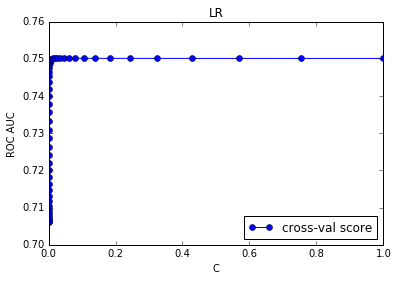

In [19]:
scores = clf.grid_scores_
    
plot_scores(scores, 'LR')

In [20]:
means = [sc.mean_validation_score for sc in scores]
min_index = np.argmin(means)
max_index = np.argmax(means)
print 'Min score: {sc:.5f} with C: {c}'.format(sc=scores[min_index].mean_validation_score, c=scores[min_index].parameters['C'])
print 'Max score: {sc:.5f} with C: {c}'.format(sc=scores[max_index].mean_validation_score, c=scores[max_index].parameters['C'])

Min score: 0.70609 with C: 1e-06
Max score: 0.75016 with C: 0.033932217719


______
# Making predictions for test data

In [21]:
test_data = pandas.read_csv('features_test.csv', index_col='match_id')

X_pick_test = get_X_pick(test_data)

group_individual_player_features(test_data)
remove_categorial_features(test_data)
remove_redunant_features(test_data)

test_data.fillna(500, inplace=True)
X_test = StandardScaler().fit_transform(test_data.values)
X_test = np.hstack((X_test, X_pick_test))

Total unique heroes: 108


In [22]:
prob = clf.best_estimator_.predict_proba(X_test)[:, 1]

In [23]:
min_i = np.argmin(prob)
max_i = np.argmax(prob)

print 'Min probability for match {match_id}: {prob:.4f}'.format(match_id=test_data.index[min_i], prob=prob[min_i])
print 'Max probability for match {match_id}: {prob:.4f}'.format(match_id=test_data.index[max_i], prob=prob[max_i])

Min probability for match 33469: 0.0081
Max probability for match 14176: 0.9966


In [24]:
df = pandas.DataFrame({
        'match_id': test_data.index,
        'radiant_win': prob
    })
df.set_index('match_id', inplace=True)

with open('test_predictions.csv', 'w') as f:
    df.to_csv(f)
    
df.head()

,radiant_win
match_id,
6,0.834697
7,0.766120
10,0.203755
13,0.875732
16,0.251208


In [25]:
df.std()

radiant_win    0.220827
dtype: float64

In [26]:
for col in data_copy:
    print col

r1_level
r1_xp
r1_gold
r1_lh
r1_kills
r1_deaths
r1_items
r2_level
r2_xp
r2_gold
r2_lh
r2_kills
r2_deaths
r2_items
r3_level
r3_xp
r3_gold
r3_lh
r3_kills
r3_deaths
r3_items
r4_level
r4_xp
r4_gold
r4_lh
r4_kills
r4_deaths
r4_items
r5_level
r5_xp
r5_gold
r5_lh
r5_kills
r5_deaths
r5_items
d1_level
d1_xp
d1_gold
d1_lh
d1_kills
d1_deaths
d1_items
d2_level
d2_xp
d2_gold
d2_lh
d2_kills
d2_deaths
d2_items
d3_level
d3_xp
d3_gold
d3_lh
d3_kills
d3_deaths
d3_items
d4_level
d4_xp
d4_gold
d4_lh
d4_kills
d4_deaths
d4_items
d5_level
d5_xp
d5_gold
d5_lh
d5_kills
d5_deaths
d5_items
first_blood_team
radiant_bottle_time
radiant_courier_time
radiant_flying_courier_time
radiant_tpscroll_count
radiant_boots_count
radiant_ward_observer_count
radiant_ward_sentry_count
radiant_first_ward_time
dire_bottle_time
dire_courier_time
dire_flying_courier_time
dire_tpscroll_count
dire_boots_count
dire_ward_observer_count
dire_ward_sentry_count
dire_first_ward_time
radiant_gold
dire_gold
radiant_lh
dire_lh
radiant_kills
d